In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys
sys.path.append("..")

import argparse
import scipy
import torch
import time
import torch.nn as nn
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F

import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

from fno_utils import FNO2d, FNODatasetSingle

In [3]:
device = "cuda"

cfg_fn = os.path.join("..", "experiments", f"config_rdb.yaml")
with open(cfg_fn, "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
pde_name = cfg["filename"].split(".h")[0]
model_weights = torch.load(os.path.join("..", "experiments", f"{pde_name}_FNO.pt"), map_location=torch.device('cuda'))

fno = FNO2d(
    num_channels=cfg["num_channels"], 
    modes1=cfg["modes"], 
    modes2=cfg["modes"], 
    width=cfg["width"], 
    initial_step=cfg["initial_step"]).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [5]:
scores = []
downsampling = [1,2,4]
for resolution in downsampling:
    batch_size = 25
    train_data = FNODatasetSingle(filename=os.path.join("..", "experiments", cfg["filename"]), reduced_resolution=resolution)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    res_scores = []
    for xxbatch, yy, gridbatch in train_loader:
        if cfg["training_type"] == "autoregressive":
            inp_shape = list(xxbatch.shape)
            inp_shape = inp_shape[:-2]
            inp_shape.append(-1)

            xxbatch = xxbatch.reshape(inp_shape)
            yyhat   = fno(xxbatch.to(device), gridbatch.to(device))
            yybatch = yy[:,:,:,10:11,:].to(device)
        else:
            xidx = 0
            xx   = xxbatch[xidx:xidx+1,...].to(device)
            grid = gridbatch[xidx:xidx+1,...].to(device)
            yhat = fno(xx[...,0,:], grid)
        break
    break

.H5 file extension is assumed hereafter


In [78]:
# Fixing parameters
scale = 7
dx    = pow(2, -scale)
k_s   = 1. / sqrt(pow(2, scale))

# Wavelet decomposition
wavelet_family = "db2"
wavelet = pywt.Wavelet(wavelet_family)
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

A = 0.0105 # db2: ~0.0105
B = wavelet.rec_len - 2

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx

def get_disc_idxs(xi, ks, inv_s):
    disc_xs = inv_s * xi - ks + B
    idx_tmp = np.searchsorted(x_wav, disc_xs)
    idxs = np.clip(idx_tmp - 1, 0, len(x_wav)-1)
    return idxs

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [82]:
y = yyhat[0,...,0,0].cpu().detach().numpy()
coeffs = pywt.dwt2(y, wavelet_family)
LL, (LH, HL, HH) = coeffs
coeff  = np.array([LL, LH, HL, HH]).reshape(-1)
nb_levels = len(coeffs) - 1

In [89]:
x_rec  = np.arange(0, 1, dx)
x_grid = cartesian_product(x_rec, x_rec)
x_grid_offset = np.expand_dims(np.expand_dims(x_grid - A, 1), 1)

inv_s = pow(2, scale - nb_levels)
ks    = np.array([[(k_1, k_2) for k_2 in range(LL.shape[1])] for k_1 in range(LL.shape[0])])
idxs  = get_disc_idxs(x_grid_offset, ks, inv_s)

final_shape_tuple = (x_rec.shape[0], x_rec.shape[0], -1)

fL_x, fL_y = fL[idxs[...,0]].reshape(final_shape_tuple), fL[idxs[...,1]].reshape(final_shape_tuple)
fH_x, fH_y = fH[idxs[...,0]].reshape(final_shape_tuple), fH[idxs[...,1]].reshape(final_shape_tuple)

disc_fLL = (fL_x * fL_y).reshape(final_shape_tuple)
disc_fLH = (fH_x * fL_y).reshape(final_shape_tuple)
disc_fHL = (fL_x * fH_y).reshape(final_shape_tuple)
disc_fHH = (fH_x * fH_y).reshape(final_shape_tuple)
disc_f   = (k_s * sqrt(inv_s) / sqrt(2)) * np.concatenate([disc_fLL, disc_fLH, disc_fHL, disc_fHH], axis=-1)

In [90]:
y_rec = np.sum(disc_f * coeff, axis=-1)

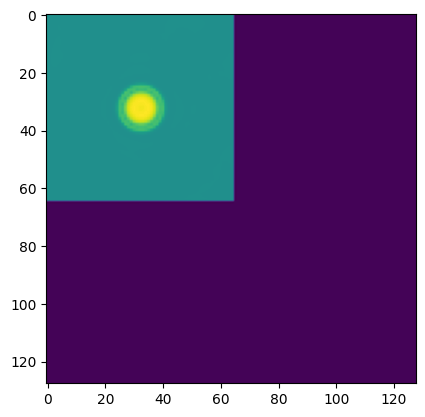

In [91]:
plt.imshow(y_rec)